In [147]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader


device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# Set the random seed
torch.manual_seed(0)

'''
assume that datasets are given, after preprocessing
'''
# Set the random seed
torch.manual_seed(0)

train_dataset = []
for i in range(10):
    if i <=5 :
        train_dataset += list(zip(torch.stack([torch.normal(0, 1, (22, 128, 8)) for _ in range(50)]), torch.zeros(50, dtype=torch.int)))
    else:
        train_dataset += list(zip(torch.stack([torch.normal(0, 3, (22, 128, 8)) for _ in range(50)]), torch.ones(50, dtype=torch.int)))

test_dataset = []
for i in range(10):
    if i <=5 :
        test_dataset += list(zip(torch.stack([torch.normal(0, 1, (22, 128, 8)) for _ in range(50)]), torch.zeros(50, dtype=torch.int)))
    else:
        test_dataset += list(zip(torch.stack([torch.normal(0, 3, (22, 128, 8)) for _ in range(50)]), torch.ones(50, dtype=torch.int)))


In [169]:
# Set the random seed
from tqdm.notebook import tqdm
import numpy as np
torch.manual_seed(0)

class SciCNN(nn.Module):

    def __init__(self):
        super(SciCNN, self).__init__()        

        self.inception1 = Inception(8, 8, 16, 8, 8)
        self.maxpool1 = nn.MaxPool2d((1, 4), stride=(1, 4), ceil_mode=True)
        self.inception2 = Inception(16, 16, 8, 16, 4)
        self.maxpool2 = nn.MaxPool2d((1, 4), stride=(1, 4), ceil_mode=True)
        self.inception3 = Inception(32, 32, 4, 32, 2)
        self.maxpool3 = nn.MaxPool2d((1, 8), stride=(1, 8), ceil_mode=True)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(22*64, 16)
        self.npc = NPC()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.inception1(x)
        x = self.maxpool1(x)
        x = self.inception2(x)
        x = self.maxpool2(x)
        x = self.inception3(x)
        x = self.maxpool3(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

class Inception(nn.Module):
    def __init__(self, in_channels, ch1, ch1_kernel, ch2, ch2_kernel):
        super(Inception, self).__init__()
        self.branch1 = BasicConv1d(in_channels, ch1, kernel=(1, ch1_kernel), padding=(0, (ch1_kernel-1)//2))
        self.branch2 = BasicConv1d(in_channels, ch2, kernel=(1, ch2_kernel), padding=(0, (ch2_kernel-1)//2))
        self.se = SEModule()

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        concat = torch.cat([branch1, branch2], dim=1)
        return self.se(concat)
        
class SEModule(nn.Module):
    def __init__(self, channels=22, reduction=4):
        super(SEModule, self).__init__()
        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction),
            nn.ReLU(),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        out = torch.squeeze(self.globalAvgPool(x))
        out = self.fc(out).view(x.size(0), x.size(1), 1, 1)
        out = x * out.expand_as(x)
        return out.permute(0, 3, 1, 2)
    
class BasicConv1d(nn.Module): 
    def __init__(self, in_channels, out_channels, kernel, padding):
        super(BasicConv1d, self).__init__()
        self.conv = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=kernel, padding=padding, bias=True),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU()
                            )
    def forward(self, x):
        return self.conv(x)
    
class NPC(nn.Module):
    def __init__(self, num_clusters=64):
        super(NPC, self).__init__()
        # 256 predefined positions of NPC clusters
        self.position = nn.Parameter(torch.from_numpy(np.random.uniform(0, 1, (num_clusters, 16, 1))).to(torch.float32), requires_grad=True)
        self.label = nn.Parameter(2*torch.ones(num_clusters), requires_grad=False)

model = SciCNN().to(device)

def npc_training_loss(output, label, model):
    # output: (batch_size, 16, 1)
    mean_output = torch.mean(output, dim=0)
    distances = torch.norm(mean_output.view(1, -1, 1) - model.npc.position.data, dim=1).squeeze()
    closest_position_index = torch.argmin(distances)
    closest_position = model.npc.position[closest_position_index]
    model.npc.label[closest_position_index] = torch.max(label)
    loss = torch.norm(mean_output - closest_position)
    return loss


model = SciCNN().to(device)
loss_function = npc_training_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-4)

model.train()
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=False)

train_loss_list = []
import time
start = time.time()
for epoch in tqdm(range(50)):
    loss=0
    for i, (images, labels) in enumerate(train_loader) :
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels, model)
        loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
    train_loss_list.append(loss/len(train_loader))
    print ("Epoch [{}] Loss: {:.4f}".format(epoch+1, loss/len(train_loader)))

end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1] Loss: 87.7185
Epoch [2] Loss: 1.5462
Epoch [3] Loss: 0.9778
Epoch [4] Loss: 0.4913
Epoch [5] Loss: 0.2404
Epoch [6] Loss: 0.1619
Epoch [7] Loss: 0.1437
Epoch [8] Loss: 0.1346
Epoch [9] Loss: 0.1270
Epoch [10] Loss: 0.1170
Epoch [11] Loss: 0.1119
Epoch [12] Loss: 0.1310
Epoch [13] Loss: 0.2066
Epoch [14] Loss: 0.2084
Epoch [15] Loss: 0.2056
Epoch [16] Loss: 0.2028
Epoch [17] Loss: 0.1992
Epoch [18] Loss: 0.1967
Epoch [19] Loss: 0.1945
Epoch [20] Loss: 0.1925
Epoch [21] Loss: 0.1909
Epoch [22] Loss: 0.1894
Epoch [23] Loss: 0.1882
Epoch [24] Loss: 0.1871
Epoch [25] Loss: 0.1860
Epoch [26] Loss: 0.1851
Epoch [27] Loss: 0.1842
Epoch [28] Loss: 0.1834
Epoch [29] Loss: 0.1826
Epoch [30] Loss: 0.1820
Epoch [31] Loss: 0.1815
Epoch [32] Loss: 0.1809
Epoch [33] Loss: 0.1803
Epoch [34] Loss: 0.1799
Epoch [35] Loss: 0.1795
Epoch [36] Loss: 0.1790
Epoch [37] Loss: 0.1786
Epoch [38] Loss: 0.1782
Epoch [39] Loss: 0.1779
Epoch [40] Loss: 0.1775
Epoch [41] Loss: 0.1773
Epoch [42] Loss: 0.1770


In [170]:
def npc_test_loss(output, model):
    mean_output = torch.mean(output, dim=0)
    distances = torch.norm(mean_output.view(1, -1, 1) - model.npc.position.data, dim=1).squeeze()
    closest_position_index = torch.argmin(distances)
    closest_position = model.npc.position[closest_position_index]
    closest_label = model.npc.label[closest_position_index]
    print("closest_label: ", closest_label, "index: ", closest_position_index)
    return torch.norm(mean_output - closest_position), closest_label

model.eval()
test_loss, correct, total = 0, 0, 0

loss_function = npc_test_loss
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=10, shuffle=False)
with torch.no_grad():  #using context manager
    for images, labels in test_loader :
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        test_loss += loss_function(output, model)[0].item()
        pred = loss_function(output, model)[1].item()
        correct += (pred==labels).sum().item()
        total += labels.size(0)

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, device='mps:0')
closest_label:  tensor(1., device='mps:0') index:  tensor(54, de

In [171]:
print(model.npc.label)
print(model.npc.position)
for i in range(64):
    if model.npc.label[i].item() != 2:
        print(model.npc.label[i].item(), model.npc.position[i].data)

Parameter containing:
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 2., 2.,
        2., 2., 0., 2., 2., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 0., 0., 2., 2., 2., 2., 2., 0., 2., 0., 2., 2., 2., 2., 2.,
        1., 2., 2., 2., 2., 2., 2., 2., 2., 2.], device='mps:0')
Parameter containing:
tensor([[[-2.1553e-12],
         [-3.0138e-13],
         [ 4.0339e-12],
         ...,
         [ 3.0463e-12],
         [-2.6853e-12],
         [-2.8688e-13]],

        [[ 2.9856e-13],
         [-1.4444e-12],
         [ 8.4482e-13],
         ...,
         [ 2.2562e-13],
         [-2.5735e-12],
         [ 5.6284e-13]],

        [[ 5.3933e-13],
         [-5.7171e-13],
         [-1.7478e-12],
         ...,
         [-1.4519e-13],
         [-1.8734e-13],
         [ 5.5929e-14]],

        ...,

        [[ 1.3730e-12],
         [ 2.1845e-12],
         [ 2.0887e-12],
         ...,
         [-5.5571e-14],
         [-4.4738e-13],
         [ 8.4345e-13]]

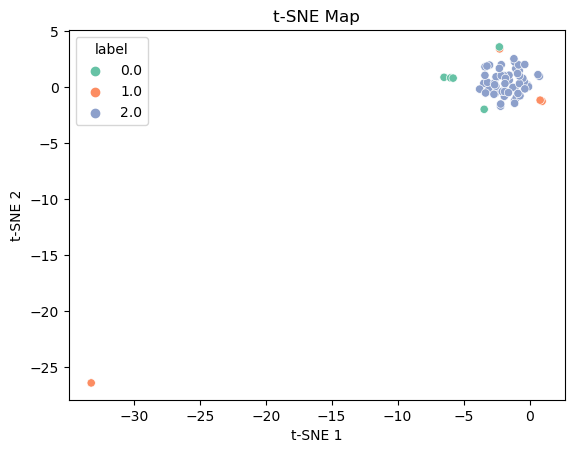

In [172]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the model.npc.position to numpy array
positions = model.npc.position.detach().cpu().numpy().squeeze()

# Convert the model.npc.label to numpy array
labels = model.npc.label.detach().cpu().numpy()

# Apply t-SNE to reduce the dimensionality
tsne = TSNE(n_components=2, random_state=0)
tsne_positions = tsne.fit_transform(positions)

# Create a DataFrame with the t-SNE positions and labels
df_tsne = pd.DataFrame({'x': tsne_positions[:, 0], 'y': tsne_positions[:, 1], 'label': labels})

# Plot the t-SNE map with hue as the label
sns.scatterplot(data=df_tsne, x='x', y='y', hue='label', palette='Set2')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Map')
plt.show()

In [142]:
model(torch.normal(0, 1, (1, 22, 128, 8)).to(device))

tensor([[-0.5777, -0.1181, -0.4115, -0.6689,  0.0895,  0.7340, -0.0701,  0.3111,
         -0.2508, -0.3647,  0.1282,  0.2300, -0.4694,  0.9344,  0.5104,  0.0209]],
       device='mps:0', grad_fn=<LinearBackward0>)

In [8]:
positions.squeeze().shape

(256, 16)

/Users/daeheonkwon/anaconda3/envs/EEG/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/daeheonkwon/anaconda3/envs/EEG/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Training Loss')

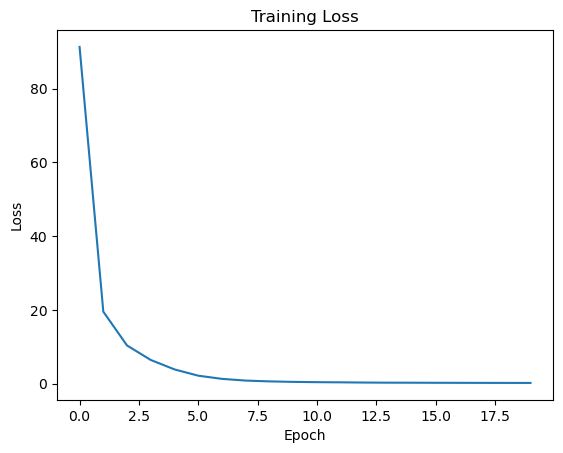

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
loss_plot = train_loss_list[:20]
sns.lineplot(x=range(len(loss_plot)), y=loss_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')


In [162]:
a = torch.tensor(1)
a.shape

torch.Size([])